<a href="https://colab.research.google.com/github/nowionlyseedaylight/CS224W/blob/main/ICA_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# do not show sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import csv
import numpy as np
import pandas as pd
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score,classification_report, accuracy_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import networkx as nx
from operator import itemgetter 


In [3]:
class1 = [86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]
class2 = [76, 90, 136, 137, 143, 152, 47, 162]
#class3 - other

In [5]:
communication_data = pd.read_csv('communication.csv', sep =';')  

In [6]:
communication_data.head()

,Sender,Recipient,EventDate
0,17,37,2010-01-02 17:40:10
1,17,136,2010-01-02 17:40:10
2,17,62,2010-01-02 17:40:10
3,17,129,2010-01-02 17:40:10
4,17,32,2010-01-02 17:40:10


In [8]:
reportsto_data = pd.read_csv('reportsto.csv', sep =';')  

In [9]:
reportsto_data.head()

,ID,ReportsToID
0,1,152
1,2,132
2,3,152
3,4,technical email account - not used by employees
4,5,36


In [10]:
class Node:
    def __init__(self, n_id):
        self.n_id = n_id
        self.clear()
        
        
    def features(self):
        features_array = np.array([self.send, self.received, self.degree, self.betweenness, self.closeness, self.neighbors_1, self.neighbors_2, self.neighbors_3 ])
        return features_array
    
    def set_label(self,l):
        if self.label == l:
            return False
        else:
            self.label = l
            return True
        
    def set_values(self,c,b,d):
        self.degree = d
        self.betweenness = b
        self.closeness = c
    
    
    def update_neighbours(self, neighbors):
        self.neighbors_2 =0
        self.neighbors_3 =0
        self.neighbors_1 =0
        
        for n in neighbors:
            nl = n.label
            if nl ==1:
                self.neighbors_1 +=1
            elif nl ==2:
                self.neighbors_2 +=1
            elif nl ==3:
                self.neighbors_3 +=1
                
    def show(self):
        return( self.n_id, 
              self.known, 
              self.label,
              self.send,
              self.received, 
              self.degree,
              self.betweenness,
              self.closeness,
              self.neighbors_1,
              self.neighbors_2,
              self.neighbors_3)
        
    def clear(self):
        self.known = False
        self.label = -1
        self.send = 0
        self.received = 0
        self.degree = -1
        self.betweenness = -1
        self.closeness = -1
        self.neighbors_1 = 0
        self.neighbors_2 = 0
        self.neighbors_3 = 0
                
            
            

In [11]:
def check_node_value(node_nr):
    if node_nr in class1:
        return 1
    if node_nr in class2:
        return 2
    return 3

In [13]:
def clear_nodes(nodes):
    for n in nodes:
        nodes[n].clear()

In [14]:
def select_known(N, source):
    known = [x[0] for x in list(source[:N])]
    unknown = [x[0] for x in list(source[N:])]
    return known, unknown

In [23]:
def prepare_nodes(k_nodes,betweennes,closeness,degree, nodes, G=G): 
    for n in k_nodes:
        node = nodes[n]
        node.known = True
        node.label = check_node_value(n)


    for n in nodes:
        node = nodes[n]
        node.set_values(closeness[n],betweennes[n],degree[n])
        node.update_neighbours(get_node_neighbours(G, n,nodes))



In [18]:

all_nodes = {}
edges_communication_all = []

for index, row in communication_data.iterrows():
    sender_id = int(row['Sender'])
    recipient_id = int(row['Recipient'])
    
    edges_communication_all.append((sender_id,recipient_id ))
    
    
    if recipient_id not in all_nodes:
        all_nodes[recipient_id] = Node(recipient_id)
        
    if sender_id not in all_nodes:
        all_nodes[sender_id]  = Node(sender_id)
        
    all_nodes[recipient_id].received +=1
    all_nodes[sender_id].send +=1
        


In [19]:
#remove duplicates:

edges_communication = []
for s,r in edges_communication_all:
    if not((s,r) in edges_communication or  (r,s) in edges_communication):
        edges_communication.append((s,r))
        
        
    

In [20]:
len(edges_communication)

3251

In [21]:
G = nx.Graph()
G.add_edges_from(edges_communication)

In [16]:
def get_node_neighbours(G,n_id,all_nodes):
    node_neighbours = []
    for nn in G.neighbors(n_id):
        node_neighbours.append(all_nodes[nn])
    return node_neighbours

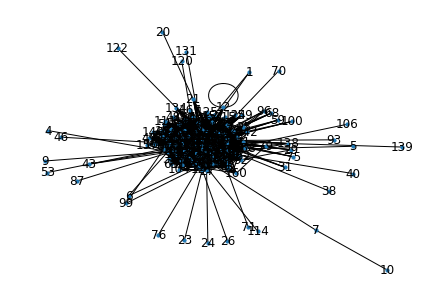

In [24]:
pos = nx.circular_layout(G)

nx.draw(G, with_labels=True, node_size=10)


In [25]:
betweenness_dict = nx.betweenness_centrality(G)
closeness_dict = nx.closeness_centrality(G)
degree_dict = dict(G.degree())

In [26]:
betweenness_sorted = sorted(betweenness_dict.items(), key = itemgetter(1), reverse = True) 
closeness_sorted = sorted(closeness_dict.items(), key = itemgetter(1), reverse = True)
degree_sorted = sorted(degree_dict.items(), key = itemgetter(1), reverse = True)


In [34]:
def train_classifier(k_nodes , nodes, classification_type='dt' ):
    # prepare train data for classifier:
    x_train = []
    y_train = []

    for k in k_nodes:
        n = nodes[k]
        x_train.append(n.features())
        y_train.append(n.label)

    if classification_type == 'dt':
        classifier = DecisionTreeClassifier( random_state =2)
    elif classification_type == 'gnb':
        classifier = GaussianNB()
    else:
        raise Exception( 'This classification type is not available') 
        
    classifier = classifier.fit(x_train, y_train)   
    return classifier

In [28]:
def run_iterative_classification( classifier, nodes_order, nodes, max_iters = 1000, G=G ):

    MAX_ITERS = max_iters
    label_changed = True
    n_iter = 0
    while label_changed and n_iter<MAX_ITERS:
        label_changed = False 
        for o in nodes_order:
            node = nodes[o]
            prev_label = node.label
            n_neighbours = get_node_neighbours(G, o,all_nodes)
            node.update_neighbours(n_neighbours)
            nf = node.features()
            n_curr_label = classifier.predict([nf])[0]
            n_changed = node.set_label(n_curr_label)
            if n_changed:
                label_changed = True
        n_iter+=1
    print('Number of iters:', n_iter)


In [29]:
def evaluate(nodes_to_evaluate, all_nodes):
    true_labels = []
    pred_labels = []
    for o in nodes_to_evaluate:
        n = all_nodes[o]
        pred_labels.append(n.label)
        true_labels.append(check_node_value(o))
    f1 = f1_score(true_labels, pred_labels, average='macro')
    accuracy = accuracy_score(true_labels, pred_labels)
    #print(classification_report(true_labels, pred_labels))
    return f1, accuracy 

In [30]:
b = betweenness_sorted
c = closeness_sorted
d = degree_sorted

In [35]:
clear_nodes(all_nodes)
known_nodes,unknown_nodes = select_known(20,d)
prepare_nodes(known_nodes, betweenness_dict, closeness_dict, degree_dict, nodes = all_nodes)
classifier = train_classifier( k_nodes = known_nodes, nodes = all_nodes)
run_iterative_classification(classifier,nodes_order = unknown_nodes,  nodes = all_nodes)
evaluate(unknown_nodes, all_nodes)

Number of iters: 2


(0.3075030750307503, 0.8503401360544217)

### Results

#### Decision Tree Classifier

|UtilityScore | Nr of known nodes| Acc |Fscore | 
|--------------|------------|----------|-------|
|Degree| 10|  4|  3| 
|Degree|20 |80 |31|
|Degree |40 |91| 32 |
|Degree |60 |93 |32|
|Degree|80 | 93| 32|
|Degree|100|  93| 32|
|Degree |120 |84 |32|
|Degree |140 |89| 31|
| |  
|Betweenness  |10  |11 |8 |
|Betweenness  |20| 5 |3| 
|Betweenness |40  |91 |32 |
|Betweenness  |60 | 64| 28|
|Betweenness  |80  |59 |26|
|Betweenness  |100 |49 |24|
|Betweenness  |120| 2 | 1|
|Betweenness | 140| 4 |2| 
||
|Closeness  |10|  4 |3|
|Closeness|20| 80| 35|
|Closeness |40| 92 |32| 
|Closeness| 60| 93| 32 |
|Closeness| 80|  94 |32 | 
|Closeness| 100|  94| 32 |
|Closeness |120 |94| 32|
|Closeness| 140 |4| 3 |

#### Naive Bayes Tree Classifier


|UtilityScore | Nr of known nodes| Acc |Fscore | 
|--------------|------------|----------|-------|
|Degree| 10| 85 |31  | 
|Degree|20 |88 |31|
|Degree |40 |91| 32 |
|Degree |60 |93 |32|
|Degree|80 | 93| 32|
|Degree|100|  94| 32|
|Degree |120 |94 |32|
|Degree |140 |89| 31|
| |  
|Betweenness  |10  |89 |31|
|Betweenness  |20| 88|31| 
|Betweenness |40  |6 |4 |
|Betweenness  |60 | 93| 32|
|Betweenness  |80  |94 |32|
|Betweenness  |100 |96 |33|
|Betweenness  |120| 96| 33|
|Betweenness | 140| 93 |32| 
||
|Closeness  |10|  88 |31|
|Closeness|20| 88| 31|
|Closeness |40| 92 |32| 
|Closeness| 60| 93| 32 |
|Closeness| 80|  94 |32 | 
|Closeness| 100|  94| 32 |
|Closeness |120 |94| 32|
|Closeness| 140 |93| 32 |